Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4897.339, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4898.865, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4898.836, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4896.080, Time=0.02 sec


/Users/vincentliantonio/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vincentliantonio/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vincentliantonio/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vincentliantonio/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vincentliantonio/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: Future

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4900.712, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.321 seconds
Best ARIMA order: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  825
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2447.040
Date:                Tue, 01 Apr 2025   AIC                           4896.080
Time:                        23:35:43   BIC                           4900.794
Sample:                    01-03-2022   HQIC                          4897.888
                         - 02-28-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        22.2321      0.852     26

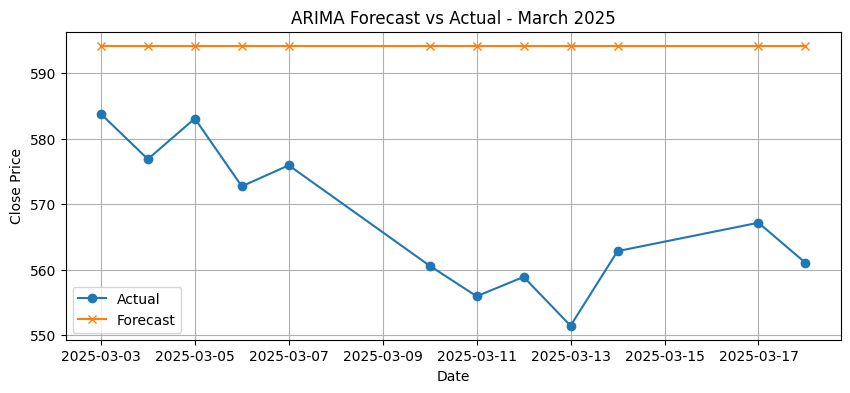

In [10]:
# Install packages if needed
%pip install numpy==1.24.4 scipy statsmodels pandas pmdarima matplotlib scikit-learn

# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Ensure plots show in JupyterLab ---
%matplotlib inline

# --- Load & Clean Data ---
df = pd.read_csv('data/sp500.csv', parse_dates=['timestamp'], index_col='timestamp')
df = df.sort_index()

# Set business day frequency and fill missing dates
df = df.asfreq('B').ffill()

# Use cleaned 'close' prices
series = df['close'].dropna()

# --- Split Data ---
train = series[series.index < '2025-03-01']
test = series[series.index >= '2025-03-01']

# --- Auto ARIMA on Training Data ---
stepwise_model = auto_arima(
    train,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("Best ARIMA order:", stepwise_model.order)
print(stepwise_model.summary())

# --- Fit Best ARIMA Model ---
best_order = stepwise_model.order
model = ARIMA(train, order=best_order)
fitted = model.fit()

# --- Forecast Next 30 Business Days ---
forecast_steps = 30
forecast_values = fitted.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast = pd.Series(forecast_values, index=forecast_index)

# --- Align Forecast with Actual Data ---
common_index = forecast.index.intersection(test.index)

print(f"\n📅 Forecast dates: {forecast.index.min().date()} to {forecast.index.max().date()}")
print(f"📅 Actual data dates: {test.index.min().date()} to {test.index.max().date()}")
print(f"✅ Common overlapping dates: {len(common_index)}")

if len(common_index) == 0:
    print("❌ No overlapping dates found between forecast and actual data.")
else:
    forecast = forecast.loc[common_index]
    actual = test.loc[common_index]

    # Drop NaNs
    comparison_df = pd.concat([actual, forecast], axis=1)
    comparison_df.columns = ['actual', 'forecast']
    comparison_df = comparison_df.dropna()

    if comparison_df.empty:
        print("❌ Overlapping dates found, but no valid (non-NaN) data to compare.")
    else:
        actual_clean = comparison_df['actual']
        forecast_clean = comparison_df['forecast']

        # --- Evaluation Metrics ---
        mse = mean_squared_error(actual_clean, forecast_clean)
        mae = mean_absolute_error(actual_clean, forecast_clean)

        print("\n📊 Evaluation Results")
        print(f"Days compared: {len(comparison_df)}")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Mean Squared Error (MSE): {mse:.2f}")

        # --- Plot Forecast vs Actual ---
        plt.figure(figsize=(10, 4))
        plt.plot(actual_clean, label='Actual', marker='o')
        plt.plot(forecast_clean, label='Forecast', marker='x')
        plt.title('ARIMA Forecast vs Actual - March 2025')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)

        # Save and show
        plt.savefig('arima_forecast_vs_actual.png', dpi=300)
        plt.show()


In [3]:
%pip install pmdarima
%pip install --upgrade numpy scipy pandas statsmodels pmdarima
%pip uninstall -y numpy scipy statsmodels pmdarima
%pip install numpy==1.24.4 scipy statsmodels pandas pmdarima


Defaulting to user installation because normal site-packages is not writeable
  Using cached pmdarima-2.0.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp39-cp39-macosx_11_0_arm64.whl (630 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 4.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 6.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
Found existing installation: statsmodels 0.14.4
Uninstalling statsmodels-0.14.4:
  Succes